c:\Users\bhuva\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\bhuva\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to C:\Users\bhuva/.cache\torch\hub\checkpoints\xception-43020ad28.pth
c:\Users\bhuva\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10: 100%|██████████| 352/352 [03:23<00:00,  1.73batch/s]


Epoch 1/10 - Train Loss: 0.8789, Train Acc: 0.7433, Val Loss: 0.4921, Val Acc: 0.8502, Time: 213.08s


Epoch 2/10: 100%|██████████| 352/352 [03:20<00:00,  1.76batch/s]


Epoch 2/10 - Train Loss: 0.3894, Train Acc: 0.8795, Val Loss: 0.2607, Val Acc: 0.9272, Time: 208.92s


Epoch 3/10: 100%|██████████| 352/352 [03:10<00:00,  1.85batch/s]


Epoch 3/10 - Train Loss: 0.2550, Train Acc: 0.9202, Val Loss: 0.1969, Val Acc: 0.9429, Time: 200.62s


Epoch 4/10: 100%|██████████| 352/352 [03:18<00:00,  1.77batch/s]


Epoch 4/10 - Train Loss: 0.1929, Train Acc: 0.9446, Val Loss: 0.1485, Val Acc: 0.9529, Time: 212.50s


Epoch 5/10: 100%|██████████| 352/352 [03:16<00:00,  1.79batch/s]


Epoch 5/10 - Train Loss: 0.1514, Train Acc: 0.9534, Val Loss: 0.1316, Val Acc: 0.9601, Time: 205.77s


Epoch 6/10: 100%|██████████| 352/352 [03:21<00:00,  1.74batch/s]


Epoch 6/10 - Train Loss: 0.1262, Train Acc: 0.9624, Val Loss: 0.1203, Val Acc: 0.9672, Time: 211.81s


Epoch 7/10: 100%|██████████| 352/352 [03:31<00:00,  1.67batch/s]


Epoch 7/10 - Train Loss: 0.1044, Train Acc: 0.9696, Val Loss: 0.0921, Val Acc: 0.9686, Time: 220.67s


Epoch 8/10: 100%|██████████| 352/352 [03:24<00:00,  1.72batch/s]


Epoch 8/10 - Train Loss: 0.0820, Train Acc: 0.9761, Val Loss: 0.0778, Val Acc: 0.9729, Time: 214.62s


Epoch 9/10: 100%|██████████| 352/352 [03:08<00:00,  1.87batch/s]


Epoch 9/10 - Train Loss: 0.0657, Train Acc: 0.9818, Val Loss: 0.0794, Val Acc: 0.9715, Time: 196.34s


Epoch 10/10: 100%|██████████| 352/352 [03:04<00:00,  1.91batch/s]


Epoch 10/10 - Train Loss: 0.0580, Train Acc: 0.9831, Val Loss: 0.0919, Val Acc: 0.9700, Time: 191.69s


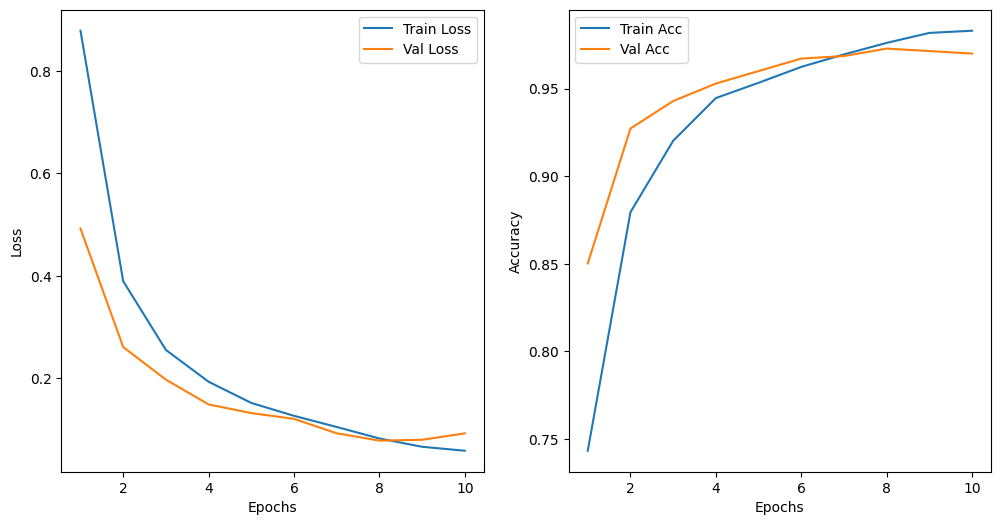

C:\Users\bhuva\AppData\Local\Temp\ipykernel_17872\2153604467.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('xception_brain_tumor.pth

ValueError: multi_class must be in ('ovo', 'ovr')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import os
import psutil
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from timm import create_model  # For Xception

# 1. Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


data_dir = r"C:\Users\bhuva\Desktop\brain_CT\split_data"
batch_size = 16
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform['val'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['val'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Initialize Xception model
model = create_model('xception', pretrained=True, num_classes=4)  # 4 classes for brain tumor detection
model = model.to(device)

# 5. Define training parameters
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-5
weight_decay = 1e-5
num_epochs = 10
early_stopping_patience = 3
best_val_loss = np.inf
patience_counter = 0
train_log = []

# 6. Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start_time = time.time()
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = val_running_loss / total
    val_acc = correct / total
    scheduler.step(val_loss)

    # Log training metrics
    epoch_time = time.time() - epoch_start_time
    mem_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
    train_log.append({
        'epoch': epoch + 1, 'train_loss': train_loss, 'train_acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc, 'epoch_time': epoch_time, 'memory_usage_mb': mem_usage
    })

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'xception_brain_tumor.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

pd.DataFrame(train_log).to_csv("xception_training_log.csv", index=False)

# 7. Plot training history
history_df = pd.DataFrame(train_log)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['epoch'], history_df['train_acc'], label='Train Acc')
plt.plot(history_df['epoch'], history_df['val_acc'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 8. ROC Curve
model.load_state_dict(torch.load('xception_brain_tumor.pth'))
model.eval()
all_labels, all_probs = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, all_probs, pos_label=1)
roc_auc = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


C:\Users\bhuva\AppData\Local\Temp\ipykernel_42152\1734332618.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'C:\Users\bhuva\Desktop\b

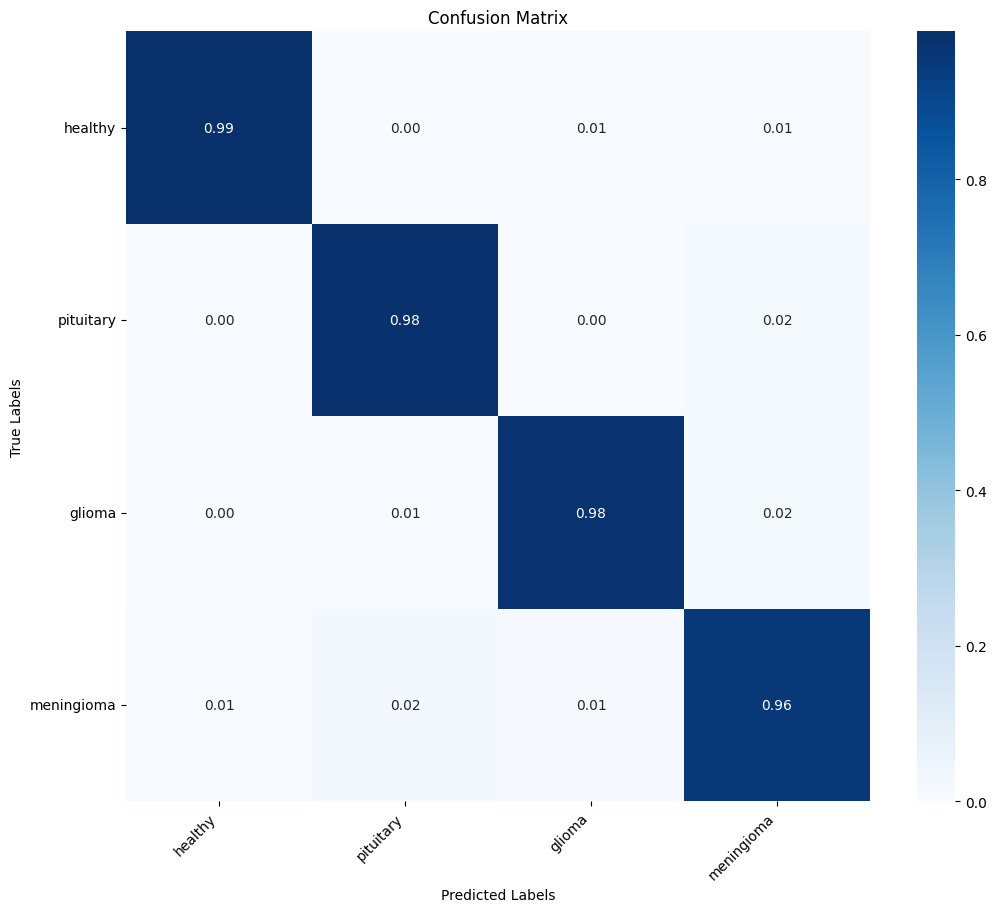

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import os
import psutil
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from timm import create_model  # For Xception

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Adjust for Xception
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

# 3. Load datasets
data_dir = r"C:\Users\bhuva\Desktop\brain_CT\split_data"
batch_size = 16
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform['val'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['val'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Initialize Xception model
model = create_model('xception', pretrained=True, num_classes=4)  # 4 classes for brain tumor detection
model = model.to(device)
# 10. Evaluate on Test Set
model.load_state_dict(torch.load(r'C:\Users\bhuva\Desktop\brain for conference\xception\xception_brain_tumor.pth'))
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Confusion Matrix Plot
class_names = ["glioma", "healthy", "meningioma", "pituitary"]
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, top_n=None):
    cm = confusion_matrix(y_true, y_pred)
    if top_n:
        misclassified_counts = np.sum(cm, axis=1) - np.diag(cm)
        top_confused_indices = np.argsort(misclassified_counts)[-top_n:]
        cm = cm[top_confused_indices, :][:, top_confused_indices]
        classes = [classes[i] for i in top_confused_indices]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(all_labels, all_preds, classes=class_names, normalize=True, top_n=10)